#### Multi-track hit classification with LSTMs

Let's see how well an LSTM model can disambiguate hits into multiple track assignments

We should do this in 2D, at least for now. Then the data structure is basically an image with channels for each track plus a channel for unassigned hits.

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)

%matplotlib notebook

Using Theano backend.
Using gpu device 7: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Utilities

In [56]:
def draw_2d_event(event, title=None, mask_ranges=None, tight=True, **kwargs):
    """
    Draw and format one 1D detector event with matplotlib.
    Params:
        event: data for one event in image format
        title: plot title
        mask_range: tuple of arrays, (lower, upper) defining a detector
            mask envelope that will be drawn on the display
        kwargs: additional keywords passed to pyplot.plot
    """
    plt.imshow(event.transpose((1,0,2)), interpolation='none', aspect='auto',
               origin='lower', **kwargs)
    if title is not None:
        plt.title(title)
    plt.xlabel('Layer')
    plt.ylabel('Pixel')
    plt.autoscale(False)
    if tight:
        plt.tight_layout()

## Data generation

Let's first develop the data by deciding the format and writing the code to generate it.

In [3]:
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

In [11]:
# Try to generate a 2-track event in two slices
t1 = generate_straight_track(det_shape)
t2 = generate_straight_track(det_shape)
n = generate_uniform_noise(1, det_shape, prob=0.2, skip_layers=seed_size)[0]

<IPython.core.display.Javascript object>


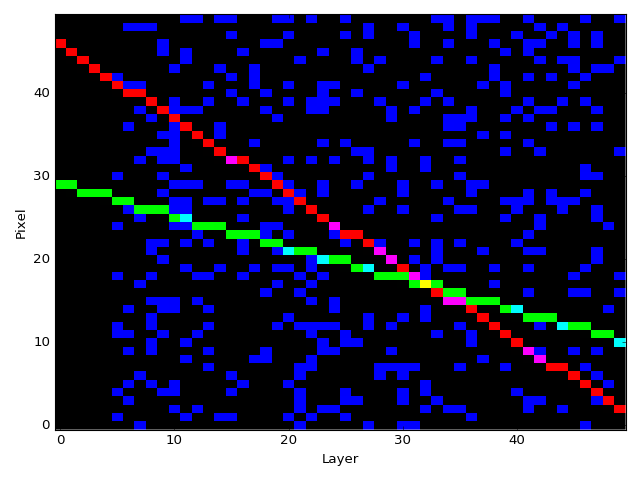

In [12]:
plt.figure()
draw_2d_event(np.stack([t1, t2, n], axis=2), cmap='jet')

<IPython.core.display.Javascript object>


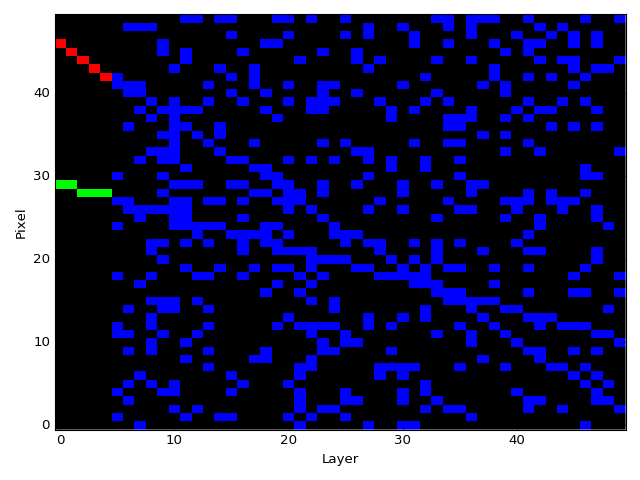

In [13]:
# Now let's show how to prepare this data for input into an algorithm.
# Need to feed only the seed part of the track into its proper channel.
event = np.zeros(det_shape + (3,))
event[:seed_size,:,0] = t1[:seed_size]
event[:seed_size,:,1] = t2[:seed_size]
event[seed_size:,:,2] = t1[seed_size:] + t2[seed_size:] + n[seed_size:]

plt.figure()
draw_2d_event(event)

<IPython.core.display.Javascript object>


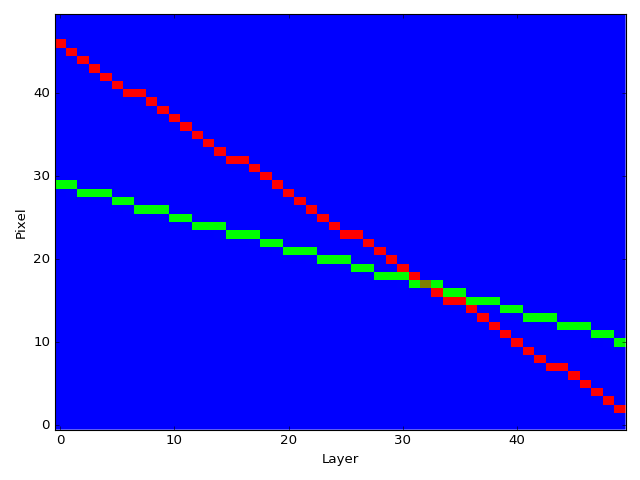

In [14]:
# Now demonstrate the model target
target = np.zeros(det_shape + (3,))
# Put the signal tracks in their respective channels
target[:,:,0] = t1
target[:,:,1] = t2
# Fill the rest as unassigned
target[:,:,2] = np.ones_like(n) - np.logical_or(t1, t2)
# Normalize the shared pixels
target /= target.sum(axis=2)[:,:,None]

plt.figure()
draw_2d_event(target)

Ok, now let's try to streamline the data generation process

In [8]:
def generate_data(num_event, det_shape, num_sig_tracks, seed_size, noise_prob):
    """Generate some data"""
    sig_tracks = [generate_straight_tracks(num_event, det_shape)
                  for _ in range(num_sig_tracks)]
    noise = generate_uniform_noise(num_event, det_shape, prob=noise_prob, skip_layers=seed_size)
    return sig_tracks, noise

def construct_input(sig_tracks, noise, seed_size):
    """
    Construct model input data format
    Output array has shape (batch, det_depth, det_width, num_tracks + 1)
    """
    num_tracks = len(sig_tracks)
    shape = noise.shape + (num_tracks + 1,)
    inputs = np.zeros(shape)
    # Fill the seeds in their assigned channels
    for i in range(num_tracks):
        inputs[:,:seed_size,:,i] = sig_tracks[i][:,:seed_size]
    # Fill the rest as unassigned
    inputs[:,seed_size:,:,-1] = (sum(sig_tracks + [noise]))[:,seed_size:]
    return inputs

def construct_target(sig_tracks):
    """Construct model target data format"""
    num_tracks = len(sig_tracks)
    shape = sig_tracks[0].shape + (num_tracks + 1,)
    target = np.zeros(shape)
    # Put the signal tracks in their respective channels
    for i in range(num_tracks):
        target[:,:,:,i] = sig_tracks[i]
    # Fill the rest as unassigned
    a = np.ones_like(sig_tracks[0])
    b = np.logical_or(*sig_tracks)
    target[:,:,:,-1] = a - b
    # Normalize the shared pixels
    target /= target.sum(axis=3)[:,:,:,None]
    # Return flattened
    return target.reshape(shape[0], -1, num_tracks + 1)

In [9]:
num_event = 51200
num_tracks = 2
noise_prob = 0.2
sig_tracks, noise = generate_data(num_event, det_shape, num_tracks, seed_size, noise_prob)

## Define an LSTM model

Let's now try to define a model which can solve this new problem

In [50]:
def build_model(det_shape, num_channels=3, hidden_dim=100):
    det_depth, det_width = det_shape
    inputs = layers.Input(shape=det_shape+(num_channels,))
    # Flatten out the channel dimension
    flat_inputs = layers.Reshape((det_depth, det_width * num_channels))(inputs)
    hidden = layers.LSTM(hidden_dim, return_sequences=True)(flat_inputs)
    hidden = layers.TimeDistributed(layers.Dense(hidden_dim, activation='relu'))(hidden)
    hidden = layers.TimeDistributed(layers.Dense(det_width * num_channels))(hidden)

    # Flatten each channel
    hidden = layers.Reshape((det_depth*det_width, num_channels))(hidden)

    # Final softmax over the channels in each pixel
    outputs = layers.TimeDistributed(layers.Activation('softmax'))(hidden)

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Training the LSTM model

In [51]:
model1 = build_model(det_shape, num_channels=num_tracks+1, hidden_dim=100)
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 50, 50, 3)     0                                            
____________________________________________________________________________________________________
reshape_7 (Reshape)              (None, 50, 150)       0           input_3[0][0]                    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 50, 100)       100400      reshape_7[0][0]                  
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribute(None, 50, 100)       10100       lstm_3[0][0]                     
___________________________________________________________________________________________

In [10]:
train_input = construct_input(sig_tracks, noise, seed_size)
train_target = construct_target(sig_tracks)

In [52]:
model1.fit(train_input, train_target, batch_size=256, nb_epoch=10)

Epoch 1/10
51200/51200 [==============================] - 139s - loss: 0.2203 - acc: 0.9518   
Epoch 2/10
51200/51200 [==============================] - 140s - loss: 0.1526 - acc: 0.9609   
Epoch 3/10
51200/51200 [==============================] - 141s - loss: 0.1126 - acc: 0.9644   
Epoch 4/10
51200/51200 [==============================] - 141s - loss: 0.0909 - acc: 0.9675   
Epoch 5/10
51200/51200 [==============================] - 140s - loss: 0.0790 - acc: 0.9697   
Epoch 6/10
51200/51200 [==============================] - 141s - loss: 0.0716 - acc: 0.9713   
Epoch 7/10
51200/51200 [==============================] - 140s - loss: 0.0661 - acc: 0.9728   
Epoch 8/10
51200/51200 [==============================] - 140s - loss: 0.0613 - acc: 0.9751   
Epoch 9/10
51200/51200 [==============================] - 140s - loss: 0.0565 - acc: 0.9766   
Epoch 10/10
51200/51200 [==============================] - 140s - loss: 0.0529 - acc: 0.9782   


In [53]:
train_pred = model1.predict(train_input, batch_size=256)

In [54]:
train_pred.shape

(51200, 2500, 3)

<IPython.core.display.Javascript object>


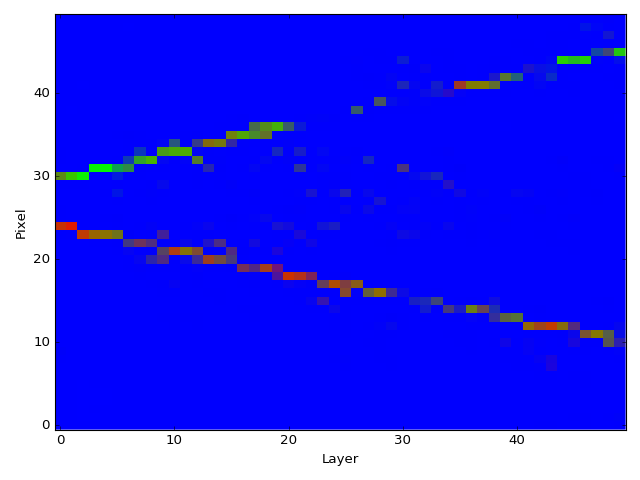

In [60]:
idx = 2
x = train_pred[idx].reshape(det_depth, det_width, num_tracks+1)
plt.figure()
draw_2d_event(x)